# How icy is sun, how fiery is snow? Playing with word embedding

We all know old, good and hackneyed examples, that are typically used to intuitively explain, what the **word embedding** technique is. We almost always come across a chart presenting a simplified, 2-dimensional vector representation of the words **queen** and **king**, which are distant from each other similarly as the words **woman** and **man**. 

Today, I’d like to go one step further and explore the meaning of the mutual position of two arbitrary selected vectors. It this particular case - relation between the **ice**-and-**fire** pair and the rest of the vectors.

## Motivation

Assume for the moment we have an embedding in the 2-dimensional space. It's not a realistic case, because in most cases such low-dimensional embedding wouldn't fulfill its purpose. So, we have a bunch of vectors or points, described with two coordinates. We choose two such vectors, say **ice** and **fire**, as mentioned above.

![Drawn using https://www.geogebra.org/m/JMMKv7cx](plot_1.png)
<center> <i>Drawn using: <a>https://www.geogebra.org/m/JMMKv7cx<a></i>

Treating the straight line passing trough these points as a new axis, we project the rest of the points onto this line. **The midpoint** between "ice" and "fire" can be treated as the origin ("point 0") of the new axis.

![Drawn using https://www.geogebra.org/m/JMMKv7cx](plot_3.png)
<center> <i>Drawn using: <a>https://www.geogebra.org/m/JMMKv7cx<a></i>

I will call the **ice** and **fire** points **poles**, to express that they show us, what is the expected meaning of being "*negative*" and "*positive*".
Briefly - I expect that embedding vectors (poinst) for "cold" words such as "winter" will get a negative value on this new axis, while "warm" words - positive values.
In this context it means that positive-valued points are those ones, that have their projections on the "right" side of the of the new axis.

Values obtained for each point are the distances from the projections to the midpoint (with sign).

## Math & code behind

One of the most convenient ways to get **embedding vectors** for natural language is to use pre-trained models distributed with [**spacy**](https://spacy.io/) library.

In [1]:
import numpy as np
import numpy.typing as npt
import spacy
import matplotlib.pyplot as plt
from functools import reduce
from operator import add

In [2]:
# Installing en_core_web_mdn
nlp = spacy.load('en_core_web_md')

In [3]:
fire = nlp('fire')
ice = nlp('ice')

In [4]:
len(fire.vector)

300

A couple of simple function calls, but there is a lot work done behind the scene. We can use **nlp** object to process whole sentences (or documents) at once. For now, we only need to process single words.

### Midpoint - origin of the new axis

We will use a **midpoint** between two initial points as the origin of the our new axis.
It can be calculated with the following formula:

<center>
$  M = (\frac{x + x_{1}}{2}, \frac{y + y_{1}}{2}, \frac{z + z_{1}}{2}, ...) $
</center>

Writing that as a function:

In [5]:
def midpoint(x: npt.NDArray, y: npt.NDArray) -> npt.NDArray:
    if (len(x) != len(y)):
        raise ValueError(
            f'Vectors come from different spaces! ' + 
            f'x: {len(x)} dimensions, y: {len(y)} dimensions')
    return (x + y) / 2

In [6]:
# midpoint(np.array([2, 3]), np.array([-1, 20]))
# midpoint(np.array([2, 3]), np.array([-1, 20, -45]))
# midpoint(fire.vector, ice.vector)

### Plotting function

In [7]:
def plot(points, lines, labels):
    points_x = [x[0] for x in points]
    points_y = [x[1] for x in points]
    
    # Lines
    for l in lines:
        plt.plot([l[0][0], l[1][0]], [l[0][1], l[1][1]])
    
    # Labels
    for coords, lbl in zip(points, labels):
        plt.text(coords[0], coords[1], lbl)
    
    # Points
    plt.plot(points_x, points_y, '.')
    plt.grid()
    plt.axhline(linewidth=1, color='black')
    plt.axvline(linewidth=1, color='black')
    plt.axis('equal')
    plt.show()

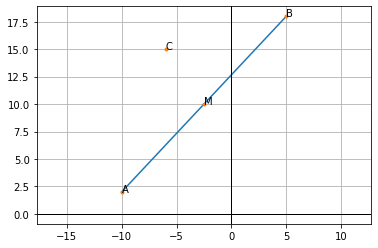

In [8]:
# Points lying on the straight line
A = np.array([-10, 2])
B = np.array([5, 18]) # 18

# a = np.array([2, 2])
# b = np.array([-2, -2])

M = midpoint(A, B)

C = np.array([-6, 15])

points = [A, B, M, C]
lines  = [[A, B]]
labels = ['A', 'B', 'M', 'C']

plot(points, lines, labels)

As we can see, the line doesn't pass through the origin. We have to apply **affine transformation** to shift the whole space, placing **midpoint AB** at (0, 0). If we do so, we can easily find orthogonal projection of the point C on the line 'marked' by the **B vector**. After we shift the space, the segment $MB$ becomes a vector as it has its start in the origin.

In [9]:
transform_matrix = np.eye(3)
transform_matrix[0:2, -1] = -M
transform_matrix

array([[  1. ,   0. ,   2.5],
       [  0. ,   1. , -10. ],
       [  0. ,   0. ,   1. ]])

If you'd like to know more details, how to construct the transformation matrix, see for example [Affine Transformation Matrices](https://articulatedrobotics.xyz/5-transformation_matrices/).

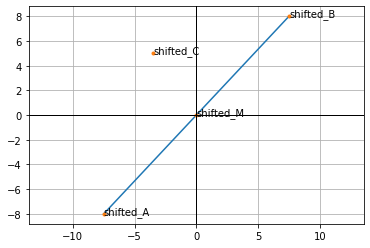

In [10]:
# tranformed_a = affine_transform_matrix @ np.vstack(a.T, [1])
def extend_with_one(vec):
    vec = vec[np.newaxis].T
    return np.vstack([vec, [1]])  

transposed  = [extend_with_one(p) for p in points]
transformed = [transform_matrix @ vec for vec in transposed]
# Removing last dimension with '1'
transformed = [vec[0:2] for vec in transformed]
aff_A, aff_B, aff_M, aff_C = transformed

lines  = [[aff_A, aff_B]]
labels = ['shifted_A', 'shifted_B', 'shifted_M', 'shifted_C']

plot(transformed, lines, labels)

### Scalar projection

We want to compute the [scalar projection](https://en.wikipedia.org/wiki/Scalar_projection) of $\bf{v}$ on $\bf{w}$ using the left-hand side of the following equation:

<center>
${\hat{\bf{w}}}^{T}\bf{v} = |\bf{v}| cos\theta $
</center>

When $\theta$ is the angle between $\bf{w}$ and $\bf{v}$, and $\hat{\bf{w}}$ is the **unit vector**, namely:

<center>
$\hat{\bf{w}} = \frac{\bf{w}}{|\bf{w}|} $
</center>

See also:
1. [The dot product](https://mathinsight.org/dot_product)
2. [Dot products duality by 3Blue1Brown](https://www.youtube.com/watch?v=LyGKycYT2v0&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab&index=9&t=216s)

In [11]:
unit_vec = (aff_B) / np.linalg.norm(aff_B)
scalar_product = unit_vec.T @ aff_C
scalar_product

array([[1.25389207]])

In [12]:
# We compute projection of C to draw a plot
proj_C = unit_vec * scalar_product

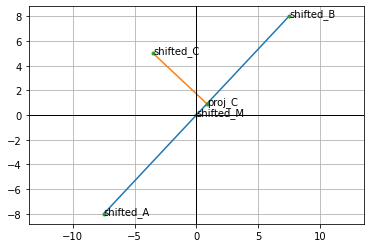

In [13]:
# Plot 
points = transformed + [proj_C]
lines  = [[aff_A, aff_B], [aff_C, proj_C]]
labels = ['shifted_A', 'shifted_B', 'shifted_M', 'shifted_C', 'proj_C']
plot(points, lines, labels)

## Axis class

Rewriting all as a function

In [57]:
class axis:

    def __init__(self, negative_pole: npt.NDArray, positive_pole: npt.NDArray):
        
        self.dims = len(negative_pole)
        
        # Original values
        self.negative_pole = negative_pole 
        self.positive_pole = positive_pole
        self.midpoint = _midpoint(negative_pole, positive_pole)  
        
        # Transformation
        self.transform = _transformation_matrix(self.dims, self.midpoint)       
        self.shifted_negative_pole = self._shift(negative_pole)
        self.shifted_positive_pole = self._shift(positive_pole)
        
        self.unit_vector = self.shifted_positive_pole / np.linalg.norm(self.shifted_positive_pole)      # shifted_midpoint is (0, 0, ...) 

    def __call__(self, vector: npt.NDArray):
        
        if (len(vector) != self.dims):
            raise ValueError(
                f'Vector length is {len(vector)}, but it should equal {self.dims}' 
            )
        
        shifted_vector = self._shift(vector)
        return (self.unit_vector.T @ shifted_vector)[0, 0]
    
    def plot(self, *args, title = "Embedding vectors", figsize = (10, 5), 
             poles = {'negative': {'label': 'Negative pole', 'color': 'blue'}, 
                      'positive': {'label': 'Positive pole', 'color':'red'}}):
   
        # Init plot
        fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
        ax.set(title=title)
        
        # Horizontal line       
        neg_value = self(self.negative_pole)
        pos_value = self(self.positive_pole)
        
        all_values = reduce(add, [a['values'] for a in args])
        all_values = all_values + [neg_value, pos_value]
        
        ax.plot(all_values, np.zeros_like(all_values), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.
        
        # Generate colours if not defined
        for group in args:

            values = group['values']
            labels = group['labels']
            color  = group['color']
            
            levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(values)/6)))[:len(values)]
            
            ax.vlines(values, 0, levels, color=color)  
            vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]

            for d, l, r, va in zip(values, levels, labels, vert):
                ax.annotate(r, xy=(d, l), xytext=(1, np.sign(l)*3),
                            textcoords="offset points", va=va, ha="right")
        
        # Show poles
        neg_pole = poles['negative']
        pos_pole = poles['positive']

        ax.vlines(neg_value, 0, 4, neg_pole['color'])  
        ax.annotate(neg_pole['label'], xy=(neg_value, 4), xytext=(4, np.sign(4)*3),
            textcoords="offset points", va=va, ha="right", weight='bold')

        ax.vlines(pos_value, 0, 4, color=pos_pole['color'])  
        ax.annotate(pos_pole['label'], xy=(pos_value, 4), xytext=(4, np.sign(4)*3),
            textcoords="offset points", va=va, ha="right", weight='bold')
        
        # Show the plot
        ax.yaxis.set_visible(False)
        ax.spines[["left", "top", "right"]].set_visible(False)
        ax.margins(y=0.1)
        
        plt.savefig("a.png")
        
        plt.show()

    def _shift(self, vector: npt.NDArray):
        extended_vector = _extend_with_one(vector)
        return (self.transform @ extended_vector)[0:self.dims]
    
        
def _extend_with_one(vector: npt.NDArray) -> npt.NDArray:
    vector = vector[np.newaxis].T
    return np.vstack([vector, [1]])      

def _transformation_matrix(dims: int, midpoint: npt.NDArray) -> npt.NDArray:
    mat = np.eye(dims + 1)
    mat[0:dims, -1] = -midpoint
    return mat   
    
def _midpoint(x: npt.NDArray, y: npt.NDArray) -> npt.NDArray:
    if (len(x) != len(y)):
        raise ValueError(
            f'Vectors come from different spaces! ' + 
            f'x: {len(x)} dimensions, y: {len(y)} dimensions')
    return (x + y) / 2

Last quick check with a simplified example:

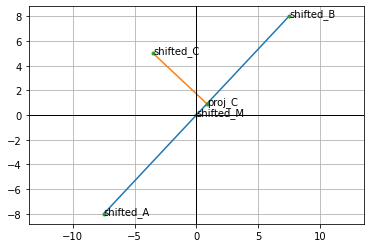

In [58]:
# Points lying on the straight line
A = np.array([-10, 2])
B = np.array([5, 18]) # 18
C = np.array([-6, 15])

axis_a_b = axis(A, B)

points = [A, B, C, axis_a_b.midpoint]
shifted_points = [axis_a_b._shift(p) for p in points]
proj_C = axis_a_b(C) * axis_a_b.unit_vector
shifted_points = shifted_points + [proj_C]

shifted_A, shifted_B, shifted_C, shifted_M, _  = shifted_points

lines  = [[shifted_A, shifted_B], [shifted_C, proj_C]]
labels = ['shifted_A', 'shifted_B', 'shifted_C', 'shifted_M', 'proj_C']
plot(shifted_points, lines, labels)

## Experiment with embeddings

In [59]:
ice_fire_axis = axis(ice.vector, fire.vector)

In [60]:
# Ice
ice_value = ice_fire_axis(ice.vector)

# Fire
fire_value = ice_fire_axis(fire.vector)

In [61]:
cold = ['polar', 'snow', 'winter', 'fridge', 'Antarctica', 'freeze']
warm = ['tropical', 'sun', 'summer', 'oven', 'Africa', 'flame']

In [62]:
cold_vecs = [nlp(w).vector for w in cold]
warm_vecs = [nlp(w).vector for w in warm]

In [63]:
cold_values = [ice_fire_axis(p) for p in cold_vecs]
warm_values = [ice_fire_axis(p) for p in warm_vecs]
warm_values

[-0.179010129140625,
 0.7686063030627324,
 0.21483235444847368,
 0.5769307333087565,
 0.830039105765312,
 2.751032938467553]

In [64]:
all_values = cold_values + warm_values + [ice_value, fire_value]
all_labels = cold + warm

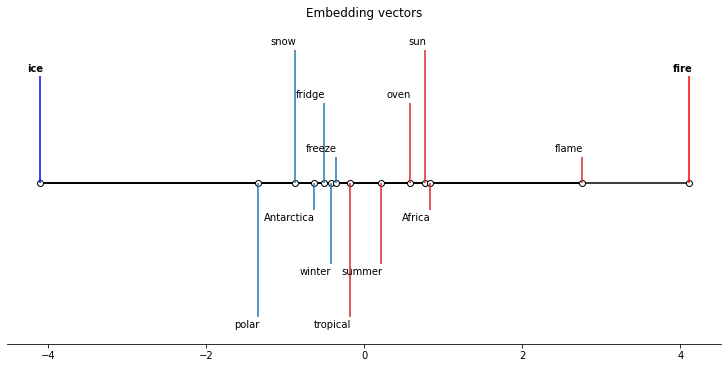

In [65]:
ice_fire_axis.plot(
        {'values': cold_values, 'labels': cold, 'color': 'tab:blue'},
        {'values': warm_values, 'labels': warm, 'color': 'tab:red'},
        poles = {'negative': {'label': 'ice', 'color': 'blue'}, 
                 'positive': {'label': 'fire', 'color': 'red'}}
    )   

## Conclusions

As we can see, in this case the meaning of the mutual position of “ice” and “fire” looks as expected. "Cold words" are closer to the *negative pole* while the "warm words* - to the *positive pole*.

To do a similar experiment by yourself, you can use my [salto](https://github.com/krzjoa/salto) package.